In [1]:
import platform, sys, os

In [2]:
# use default GMTSAR installation path
PATH = os.environ['PATH']
if PATH.find('GMTSAR') == -1:
    PATH = os.environ['PATH'] + ':/usr/local/GMTSAR/bin/'
    %env PATH {PATH}

In [3]:
!pip install asf-search

In [4]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import json
from dask.distributed import Client
import dask

from pygmtsar import S1, Stack, tqdm_dask, NCubeVTK, ASF, XYZTiles

In [5]:
# plotting modules
import pyvista as pv
# magic trick for white background
pv.set_plot_theme("document")
import panel
panel.extension('vtk')
from contextlib import contextmanager
import matplotlib.pyplot as plt
@contextmanager
def mpl_settings(settings):
    original_settings = {k: plt.rcParams[k] for k in settings}
    plt.rcParams.update(settings)
    yield
    plt.rcParams.update(original_settings)
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
%matplotlib inline

In [6]:
# define Pandas display settings
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

In [31]:
# Hunga Tonga Arpai, Jan. 15, 2022 - POLYGON((-175.4135 -20.5647,-175.3622 -20.5647,-175.3622 -20.5224,-175.4135 -20.5224,-175.4135 -20.5647))

SELECTION = "TWAITES"


if SELECTION == "TWAITES":
    # POLYGON((-83.2583 -73.6397,-83.3385 -73.8567,-82.5129 -74.0471,-80.2502 -73.9392,-81.0891 -73.4494,-83.2583 -73.6397))
    # WKT

    SCENES = """
S1A_IW_SLC__1SSH_20210308T082926_20210308T082953_036904_045743_2075-SLC
S1A_IW_SLC__1SSH_20210320T082926_20210320T082953_037079_045D60_4C31-SLC
S1A_IW_SLC__1SSH_20210401T082926_20210401T082953_037254_046368_3193-SLC
S1A_IW_SLC__1SSH_20210413T082926_20210413T082953_037429_046976_769A-SLC
S1A_IW_SLC__1SSH_20210425T082927_20210425T082954_037604_046F80_3BE0-SLC
S1A_IW_SLC__1SSH_20210507T082928_20210507T082955_037779_04757A_ECFB-SLC
S1A_IW_SLC__1SSH_20210519T082928_20210519T082955_037954_047AC6_8163-SLC
S1A_IW_SLC__1SSH_20210531T082929_20210531T082956_038129_048006_1A86-SLC
S1A_IW_SLC__1SSH_20210612T082930_20210612T082957_038304_048536_D749-SLC
S1A_IW_SLC__1SSH_20210624T082930_20210624T082957_038479_048A6D_16B3-SLC
S1A_IW_SLC__1SSH_20210718T082932_20210718T082959_038829_0494F3_E530-SLC
S1A_IW_SLC__1SSH_20210706T082931_20210706T082958_038654_048FB4_0455-SLC
S1A_IW_SLC__1SSH_20210823T082934_20210823T083001_039354_04A5E6_1AE6-SLC
S1A_IW_SLC__1SSH_20210904T082934_20210904T083001_039529_04ABE9_CC9D-SLC
S1A_IW_SLC__1SSH_20210916T082935_20210916T083002_039704_04B1E2_AF2F-SLC
S1A_IW_SLC__1SSH_20210730T082932_20210730T082959_039004_049A26_50E4-SLC
S1A_IW_SLC__1SSH_20210928T082935_20210928T083002_039879_04B7E5_B88A-SLC
"""

SCENES = list(filter(None, SCENES.split('\n')))
print (f'Scenes defined: {len(SCENES)}')

    geojson = '''
    {
      "type": "Feature",
      "geometry": {
        "type": "LineString",
        "coordinates": [      
                      [-82.9114, -74.1209],
            [-80.4734, -73.5324],
            [-83.5616, -72.5449],
            [-85.8913, -73.0969],
            [-86.2434, -73.3238],
            [-83.5345, -74.2611],
            [-82.9114, -74.1209]
      ]
      },
      "properties": {}
    }
    '''
    SUBSWATH = 1
    WORKDIR      = 'raw_ARSI_RSCD_TWAITES'
    DATADIR      = 'data_ARSI_RSCD_TWAITES'

In [33]:

AOI = gpd.GeoDataFrame.from_features([json.loads(geojson)])

In [34]:
# Set these variables to None and you will be prompted to enter your username and password below.
username = 'karisuvtol'
password = '-i-q$?Xd$25aY9%'

# download required polarization and subswaths only
asf = ASF(username, password)
asf.download(DATADIR, SCENES, SUBSWATH)

In [35]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:41501/status,
Dashboard: http://127.0.0.1:41501/status,Workers: 4
Total threads: 12,Total memory: 46.75 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37351,Workers: 4
Dashboard: http://127.0.0.1:41501/status,Total threads: 12
Started: Just now,Total memory: 46.75 GiB
Comm: tcp://127.0.0.1:46151,Total threads: 3
Dashboard: http://127.0.0.1:45197/status,Memory: 11.69 GiB
Nanny: tcp://127.0.0.1:37109,


In [36]:
scenes = S1.scan_slc(DATADIR, subswath=SUBSWATH)

In [37]:
sbas = Stack(WORKDIR, drop_if_exists=True).set_scenes(scenes)
sbas.to_dataframe()

NOTE: auto set reference scene 2021-03-08. You can change it like Stack.set_reference("2022-01-20")


,datetime,orbit,mission,polarization,subswath,datapath,metapath,orbitpath,geometry
date,,,,,,,,,
2021-03-08,2021-03-08 08:29:27,D,S1A,HH,1,data_ARSI_RSCD_TWAITES/S1A_IW_SLC__1SSH_20210308T082926_20210308T082953_036904_045743_2075.SAFE/...,data_ARSI_RSCD_TWAITES/S1A_IW_SLC__1SSH_20210308T082926_20210308T082953_036904_045743_2075.SAFE/...,data_ARSI_RSCD_TWAITES/S1A_OPER_AUX_POEORB_OPOD_20210328T121754_V20210307T225942_20210309T005942...,"MULTIPOLYGON (((-80.04271 -73.54032, -80.15532 -73.50908, -80.26631 -73.47811, -80.37574 -73.447..."
2021-03-20,2021-03-20 08:29:27,D,S1A,HH,1,data_ARSI_RSCD_TWAITES/S1A_IW_SLC__1SSH_20210320T082926_20210320T082953_037079_045D60_4C31.SAFE/...,data_ARSI_RSCD_TWAITES/S1A_IW_SLC__1SSH_20210320T082926_20210320T082953_037079_045D60_4C31.SAFE/...,data_ARSI_RSCD_TWAITES/S1A_OPER_AUX_POEORB_OPOD_20210409T121940_V20210319T225942_20210321T005942...,"MULTIPOLYGON (((-80.04338 -73.54050, -80.15600 -73.50926, -80.26701 -73.47829, -80.37645 -73.447..."


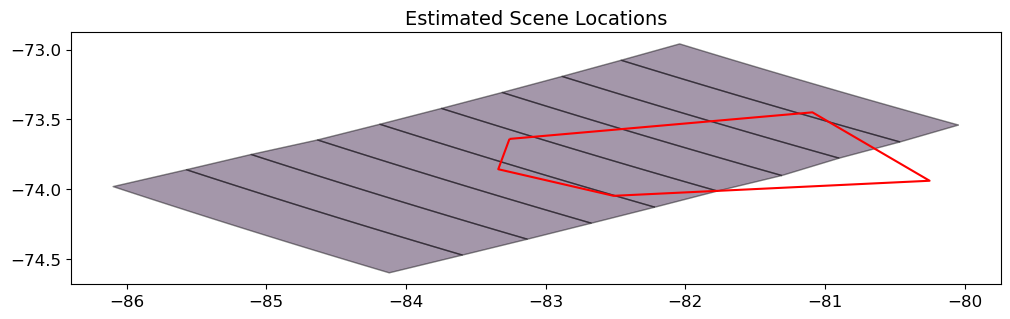

In [38]:
sbas.plot_scenes(AOI=AOI, aspect='equal')

In [39]:
sbas.compute_reframe(AOI)

Reframing:   0%|          | 0/2 [00:00<?, ?it/s]

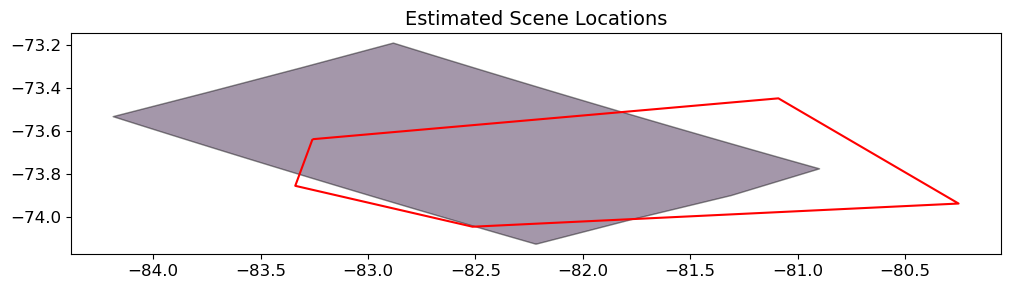

In [40]:
sbas.plot_scenes(AOI=AOI, aspect='equal')

In [41]:
sbas.download_dem(AOI)

DEM Downloading:   0%|          | 0/1 [00:00<?, ?it/s]

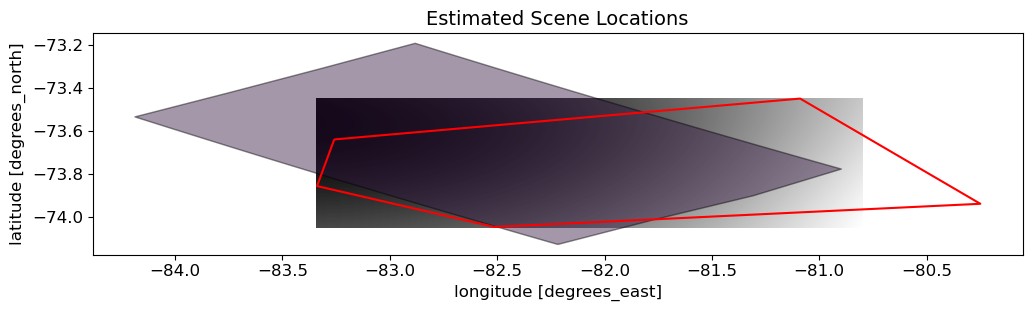

In [42]:
sbas.plot_scenes(AOI=AOI)


## Align Images



In [43]:
if os.path.exists('/.dockerenv') and not 'google.colab' in sys.modules:
    # use special joblib backend in Docker containers
    sbas.compute_align(joblib_aligning_backend='threading')
else:
    sbas.compute_align()

Aligning Reference:   0%|          | 0/1 [00:00<?, ?it/s]

Aligning Repeat:   0%|          | 0/1 [00:00<?, ?it/s]

Convert Subswath:   0%|          | 0/2 [00:00<?, ?it/s]

In [44]:
sbas.compute_geocode(1)

Radar Transform Computing:   0%|          | 0/12 [00:00<?, ?it/s]

Radar Transform Saving:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Radar Transform Indexing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/opt/conda/lib/python3.11/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


Radar Inverse Transform Computing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Satellite Look Vector Computing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

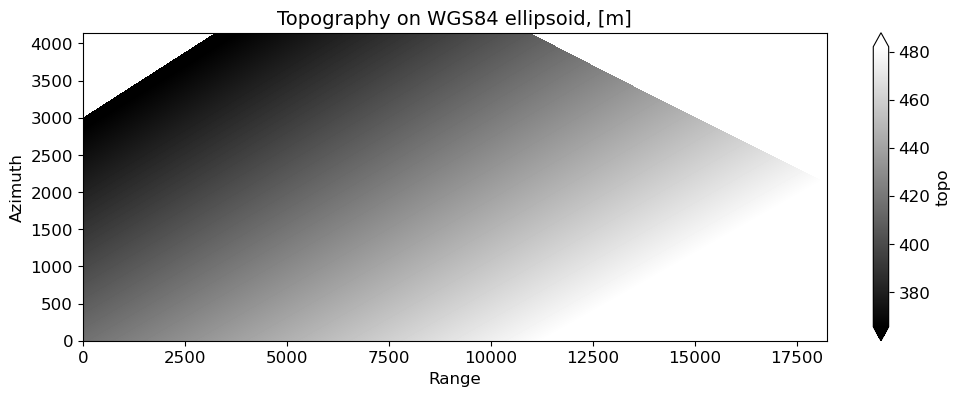

In [45]:
sbas.plot_topo(quantile=[0.01, 0.99])

In [46]:
baseline_pairs = sbas.sbas_pairs(days=24)
# optionally, drop dates having less then 2 pairs
#baseline_pairs = sbas.sbas_pairs_limit(baseline_pairs, limit=2, iterations=2)
# optionally, drop all pairs connected to the specified dates
#baseline_pairs = sbas.sbas_pairs_filter_dates(baseline_pairs, ['2021-01-01'])
baseline_pairs

,ref,rep,ref_baseline,rep_baseline,pair,baseline,duration,rel
0,2021-03-08,2021-03-20,-0.0,53.14,2021-03-08 2021-03-20,53.14,12,NaT


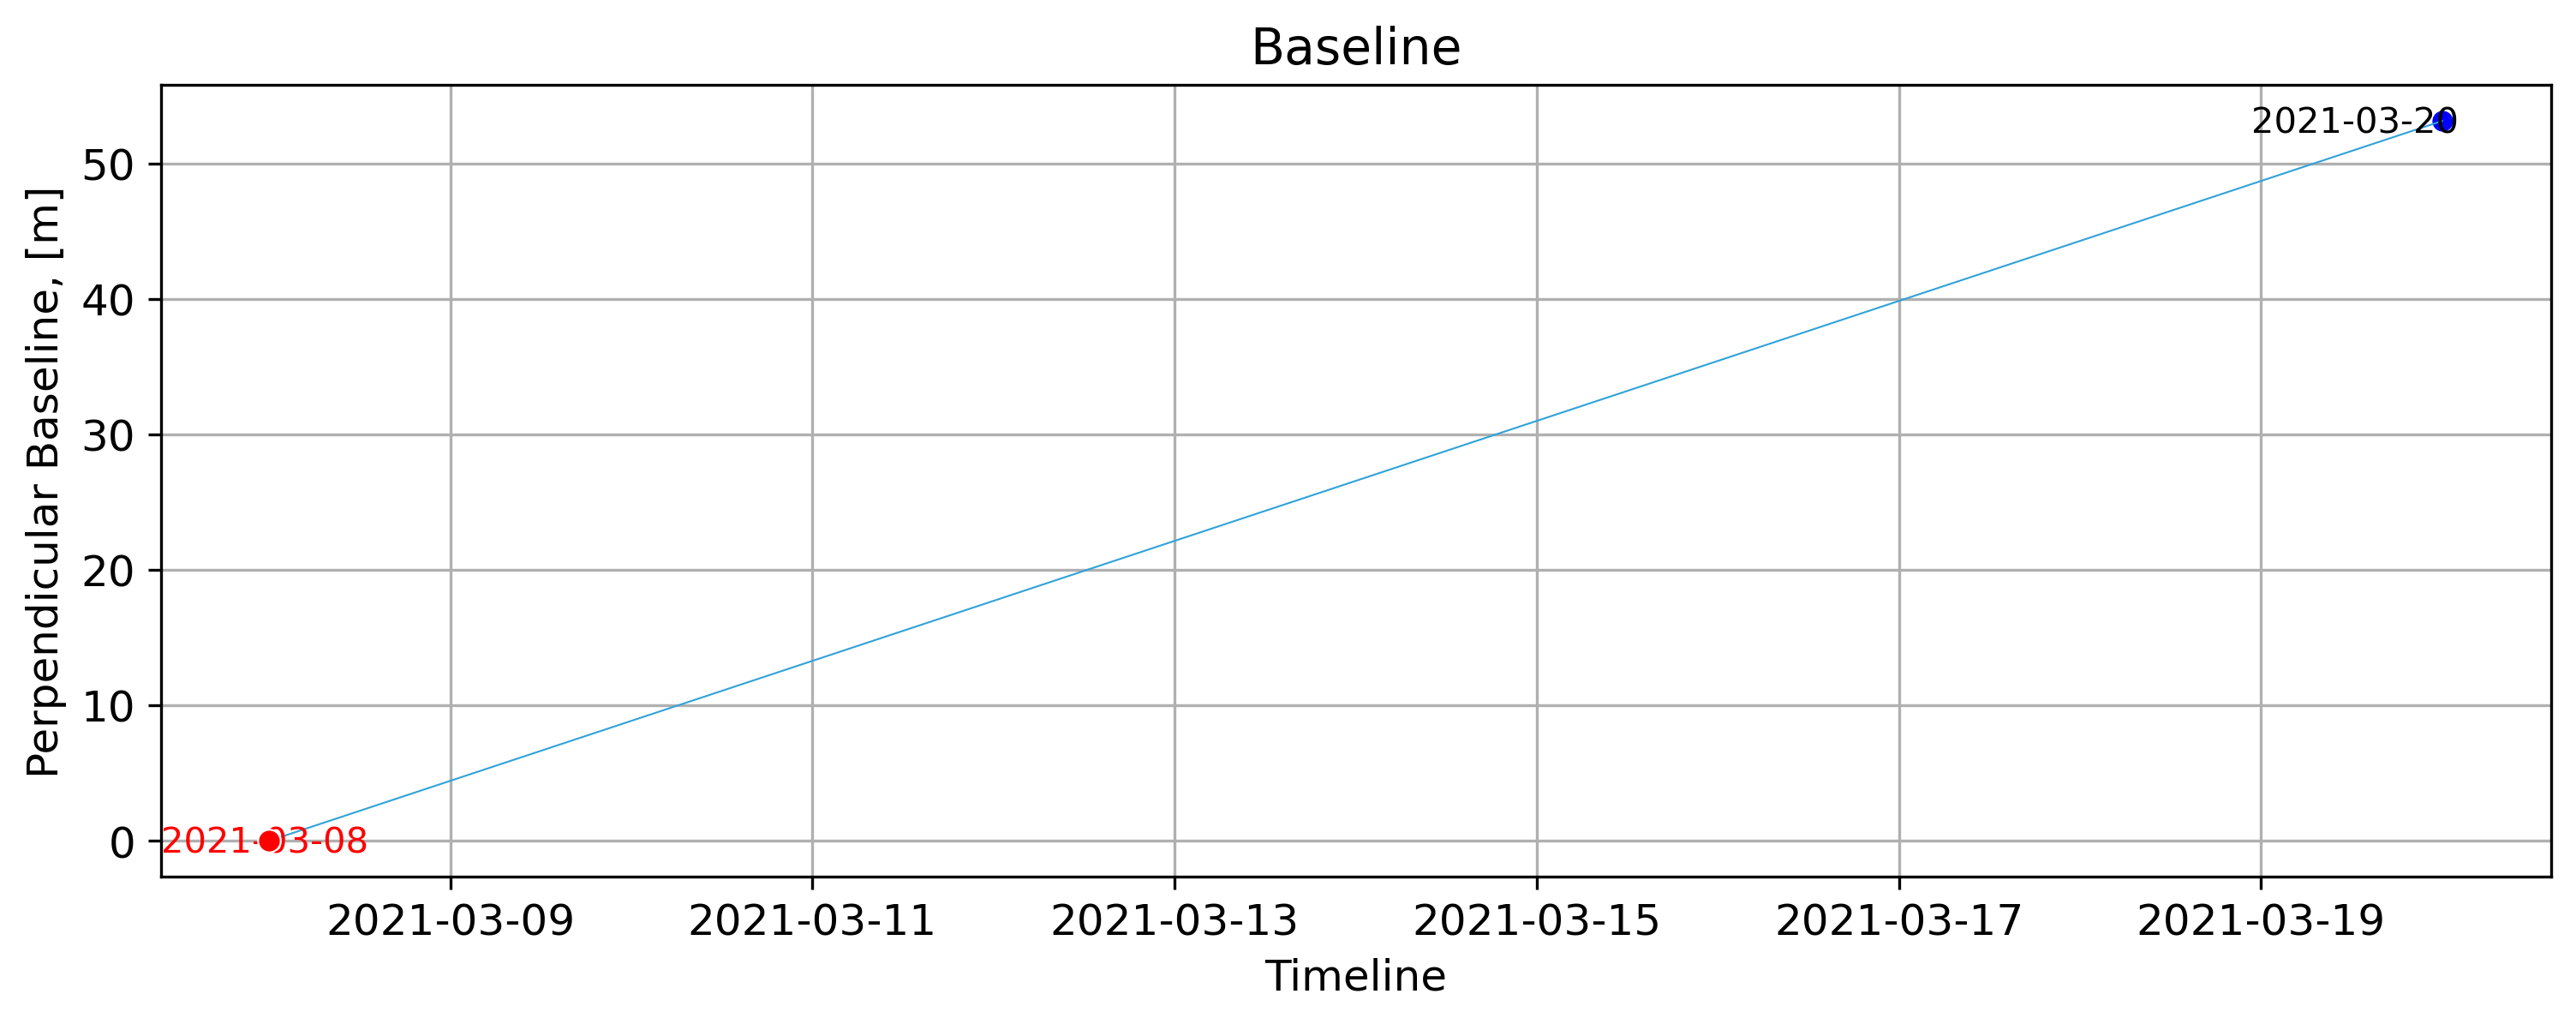

In [47]:
with mpl_settings({'figure.dpi': 300}):
    sbas.plot_baseline(baseline_pairs)